# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


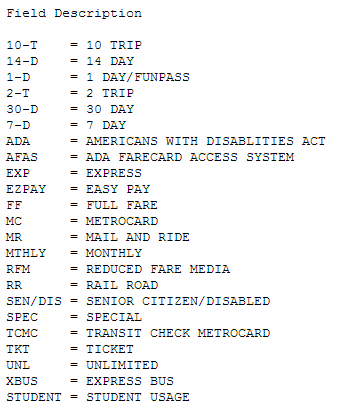

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation  import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

In [2]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [3]:
! wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy
! mv MTA_Fare.npy $PUIDATA

--2018-12-05 21:22:34--  https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy [following]
--2018-12-05 21:22:34--  https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10708880 (10M) [application/octet-stream]
Saving to: ‘MTA_Fare.npy’

MTA_Fare.npy        100%[===================>]  10.21M  --.-KB/s    in 0.08s   

2018-12-05 21:22:34 (132 MB/s) - ‘MTA_Fare.npy’ saved [10708880/10708880]



In [4]:
mta = np.load(os.getenv("PUIDATA") + "/MTA_Fare.npy")

In [5]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [6]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [7]:
# convert -1 into nan

mta = mta.astype(float)
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        mta[i,j][mta[i,j]==-1] = np.NaN

In [8]:
dateRange = pd.date_range('05/19/2010', '02/8/2014', freq='W')

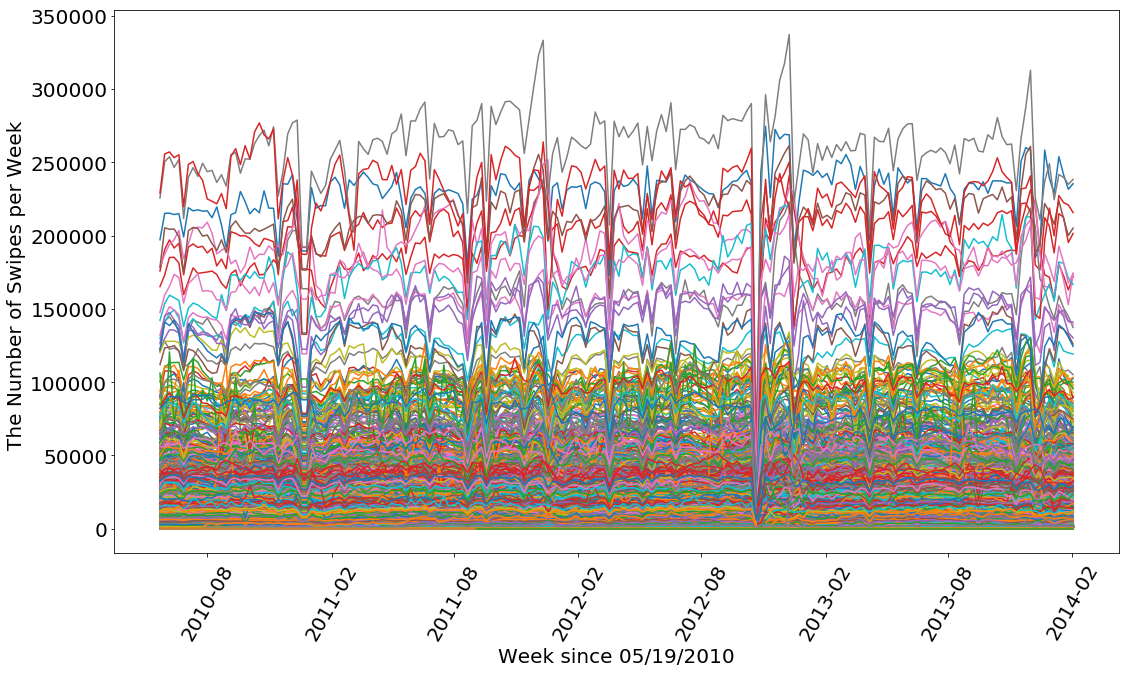

In [9]:
pl.figure(figsize(18,10))
pl.xticks(rotation=60)
pl.xlabel("Week since 05/19/2010")
pl.ylabel("The Number of Swipes per Week ")

for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plot(dateRange, mta[i,j])

## Figure 1:

Here is a time series about the Number of Swipes per Week  each station each ride type since 05/21/2010 to 02/8/2014, 194 weeks. Most data fluctuate in 0 to 100000. But some data sets vibrate to 350000 and have similar trend.

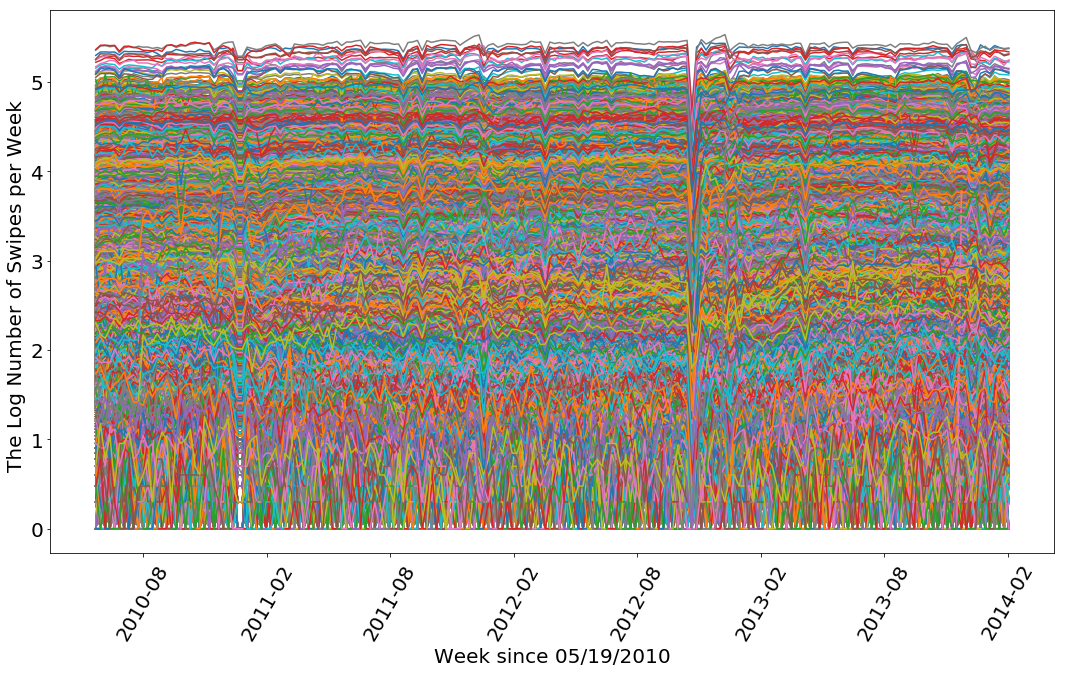

In [10]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(18,10))
pl.xticks(rotation=60)
pl.xlabel("Week since 05/19/2010")
pl.ylabel("The Log Number of Swipes per Week ")

for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plot(dateRange, log10(mta[i,j]))

## Figure 2:

Here is a time series about the Log Number of Swipes per Week each station each ride type since 05/21/2010 to 02/8/2014, 194 weeks. Most log data fluctuate in 0 to 5 and some of them have similar trend.

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [11]:
thresholds = []
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        thresholds.append(np.nanmean(mta[i,j])-3*np.nanstd(mta[i,j]))

In [12]:
ind_drops = []
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        n = i * mta.shape[1] + j
        #print(type(list(mta[i,j])))
        #print(list(mta[i,j]).index(mta[i,j]<thresholds[n]))
        ind_drop = np.argwhere(mta[i,j]<thresholds[n])
        ind_drop = [k for a in ind_drop for k in a ]
        if ind_drop:
            #print(ind_drop)
            ind_drops.extend(ind_drop)

In [13]:
d = defaultdict(int)
for i in ind_drops:
    d[i] += 1
#print(d)
result = sorted(d.items(),key = lambda d:d[1],reverse=True)

In [14]:
#result = max(d.items(), key=lambda x: x[1])
print(result[0])
print("The max number", result[0][0], "occurs", result[0][1], "times")
print(result[1])
print("The second max number", result[1][0], "occurs", result[1][1], "times")

(126, 2988)
The max number 126 occurs 2988 times
(127, 296)
The second max number 127 occurs 296 times


In [15]:
print(dateRange[result[0][0]])
print(dateRange[result[1][0]])

2012-10-21 00:00:00
2012-10-28 00:00:00


https://www.nytimes.com/2012/10/31/us/hurricane-sandy-barrels-region-leaving-battered-path.html

https://en.wikipedia.org/wiki/Hurricane_Sandy

Around that time, the new york is suffered from Hurricane Sandy, which is almost impossible to take subway

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [16]:
mtaRideType = np.nanmean(mta,axis=0)
mtaRideType.shape

(23, 194)

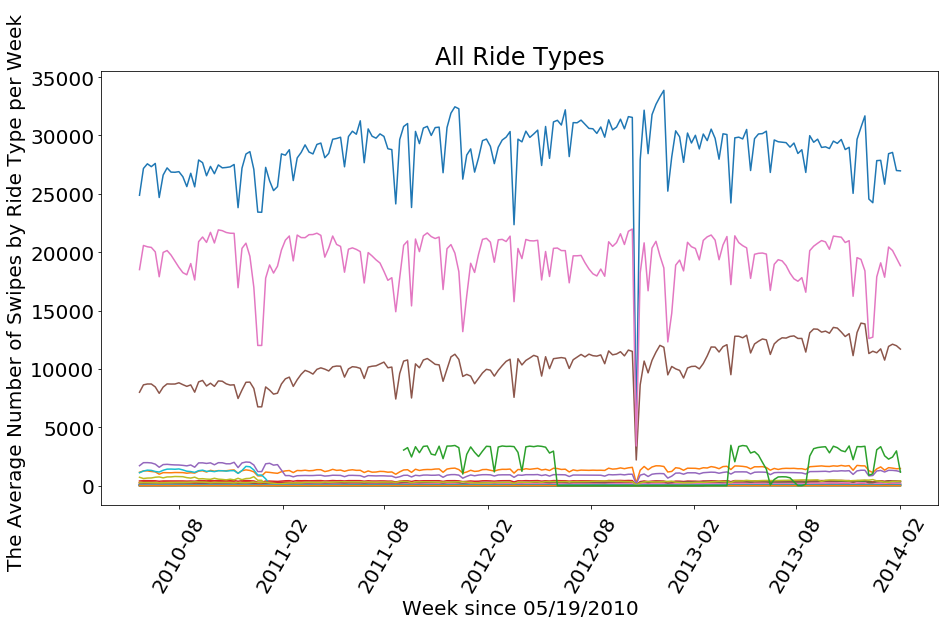

In [17]:
pl.figure(figsize(15,8))
pl.xticks(rotation=60)
pl.title("All Ride Types")
pl.xlabel("Week since 05/19/2010")
pl.ylabel("The Average Number of Swipes by Ride Type per Week ")

for i in range(mtaRideType.shape[0]):
    plot(dateRange, mtaRideType[i])

## Figure 3

Here is a time series about the Average Number of Swipes by Ride Type per Week since 05/21/2010 to 02/8/2014, 194 weeks. I plot this figure to cheat if there is any trend in those time series. Form this plot, we can see those time series real have some trends. 

In [18]:
mtaRideTypeDf = pd.DataFrame(mtaRideType).T
mtaRideTypeDf.head()

0            1           2           3           4            5   \
0  24880.119048  1148.320346  103.465368  403.790043  101.316017  8003.123377   
1  27173.229935  1265.798265  111.683297  432.167028  139.594360  8637.327549   
2  27573.708423  1266.077754  111.524838  431.248380  123.097192  8710.647948   
3  27329.751620  1215.123110  112.447084  424.166307   80.840173  8710.049676   
4  27607.099138  1182.883621  110.243534  420.006466   75.883621  8460.012931   

             6          7           8            9  ...          13  \
0  18510.686147  21.781385  721.205628  1108.294372 ...  266.523810   
1  20577.861171  25.698482  613.351410  1253.845987 ...  329.605206   
2  20467.684665  26.516199  652.328294  1329.453564 ...  327.295896   
3  20410.542117  24.235421  659.855292  1309.438445 ...  317.697624   
4  20030.176724  22.661638  723.663793  1214.323276 ...  297.172414   

            14          15         16       17          18         19  \
0  1710.194805  129.456710  61.084416  0.00000  269.898268  45.584416   
1  1969.778742  150.127983  70.136659  0.00000  264.019523  47.006508   
2  1974.349892  150.267819  70.449244  0.00000  263.889849  46.291577   
3  1949.349892  147.082073  69.987041  0.00000  263.609071  46.717063   
4  1843.907328  143.053879  68.821121  0.37931  258.137931  43.743534   

          20        21  22  
0  13.264069  0.774892 NaN  
1  13.275488  1.028200 NaN  
2  14.017279  1.004320 NaN  
3  14.233261  1.045356 NaN  
4  13.605603  0.974138 NaN  

[5 rows x 23 columns]

In [19]:
mtaRideTypeDf.columns = ridetype

In [20]:
mtaRideTypeDf.head()

10t          14d          1d          2t         30d           7d  \
0  24880.119048  1148.320346  103.465368  403.790043  101.316017  8003.123377   
1  27173.229935  1265.798265  111.683297  432.167028  139.594360  8637.327549   
2  27573.708423  1266.077754  111.524838  431.248380  123.097192  8710.647948   
3  27329.751620  1215.123110  112.447084  424.166307   80.840173  8710.049676   
4  27607.099138  1182.883621  110.243534  420.006466   75.883621  8460.012931   

            ada       afas         exp           ez  ...        month  \
0  18510.686147  21.781385  721.205628  1108.294372  ...   266.523810   
1  20577.861171  25.698482  613.351410  1253.845987  ...   329.605206   
2  20467.684665  26.516199  652.328294  1329.453564  ...   327.295896   
3  20410.542117  24.235421  659.855292  1309.438445  ...   317.697624   
4  20030.176724  22.661638  723.663793  1214.323276  ...   297.172414   

           rfm          rr        sen     spec        tcmc          t  \
0  1710.194805  129.456710  61.084416  0.00000  269.898268  45.584416   
1  1969.778742  150.127983  70.136659  0.00000  264.019523  47.006508   
2  1974.349892  150.267819  70.449244  0.00000  263.889849  46.291577   
3  1949.349892  147.082073  69.987041  0.00000  263.609071  46.717063   
4  1843.907328  143.053879  68.821121  0.37931  258.137931  43.743534   

       umlim      xbus  stud  
0  13.264069  0.774892   NaN  
1  13.275488  1.028200   NaN  
2  14.017279  1.004320   NaN  
3  14.233261  1.045356   NaN  
4  13.605603  0.974138   NaN  

[5 rows x 23 columns]

In [21]:
mtaRideTypeRollingMean = pd.rolling_mean(mtaRideTypeDf, window=4)

In [22]:
mtaRideTypeRollingMean.head()

10t          14d          1d          2t         30d           7d  \
0           NaN          NaN         NaN         NaN         NaN          NaN   
1           NaN          NaN         NaN         NaN         NaN          NaN   
2           NaN          NaN         NaN         NaN         NaN          NaN   
3  26739.202256  1223.829869  109.780147  422.842940  111.211936  8515.287137   
4  27420.947279  1232.470687  111.474688  426.897045  104.853836  8629.509526   

            ada       afas         exp           ez  ...        month  \
0           NaN        NaN         NaN          NaN  ...          NaN   
1           NaN        NaN         NaN          NaN  ...          NaN   
2           NaN        NaN         NaN          NaN  ...          NaN   
3  19991.693525  24.557872  661.685156  1250.258092  ...   310.280634   
4  20371.566169  24.777935  662.299697  1276.765318  ...   317.942785   

           rfm          rr        sen      spec        tcmc          t  \
0          NaN         NaN        NaN       NaN         NaN        NaN   
1          NaN         NaN        NaN       NaN         NaN        NaN   
2          NaN         NaN        NaN       NaN         NaN        NaN   
3  1900.918333  144.233646  67.914340  0.000000  265.354178  46.399891   
4  1934.346463  147.632938  69.848516  0.094828  262.414093  45.939670   

       umlim      xbus  stud  
0        NaN       NaN   NaN  
1        NaN       NaN   NaN  
2        NaN       NaN   NaN  
3  13.697524  0.963192   NaN  
4  13.782908  1.013003   NaN  

[5 rows x 23 columns]

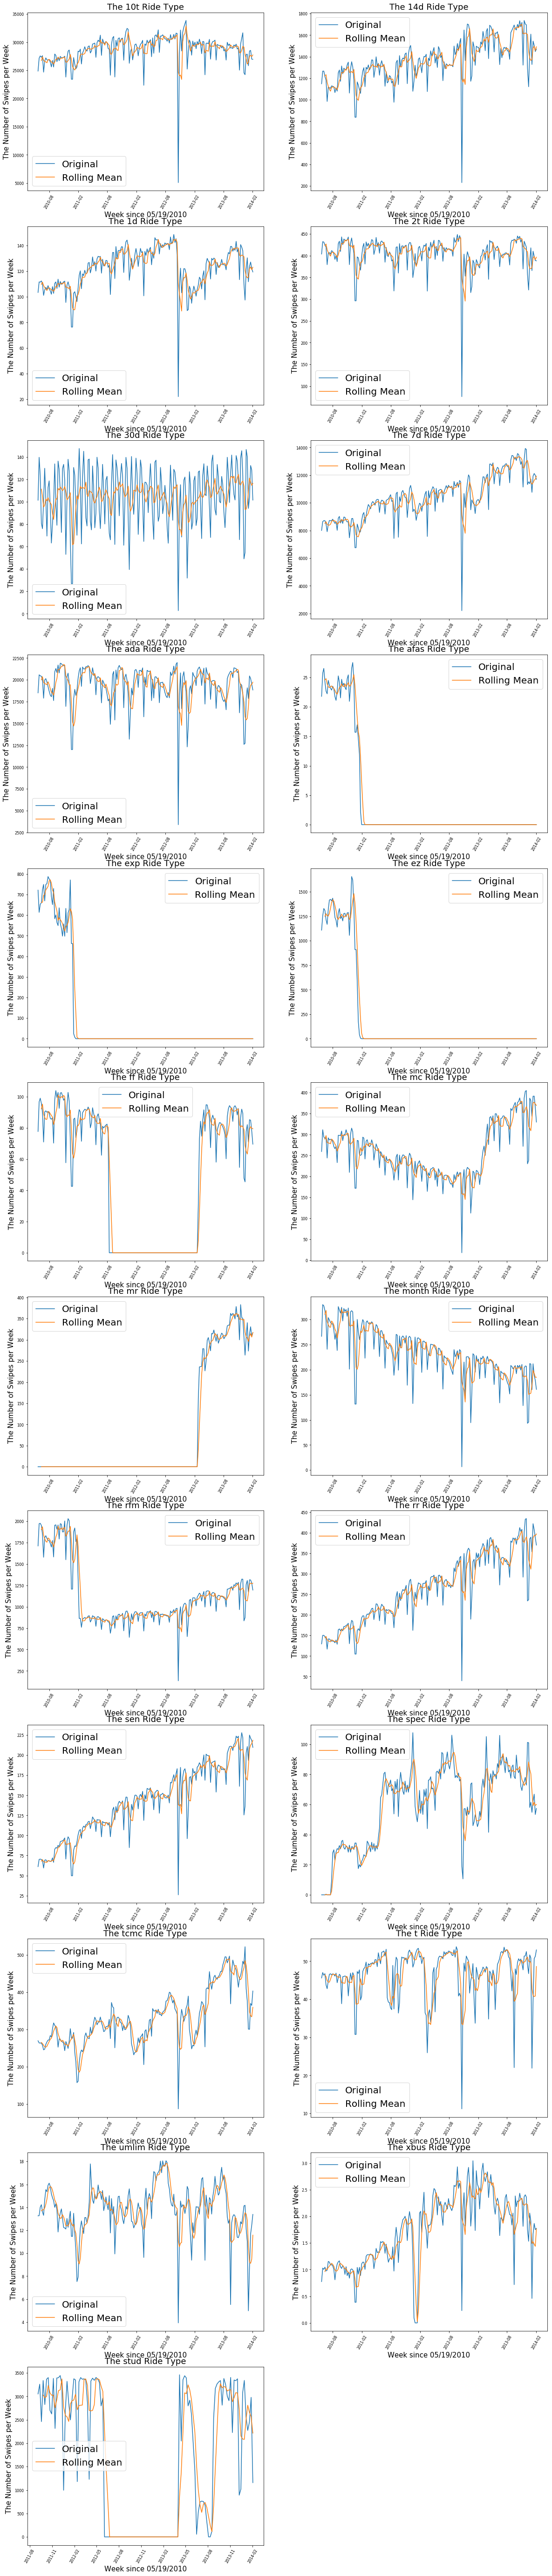

In [23]:
fig = pl.figure(figsize=(20,100))
for i in range(mtaRideTypeDf.shape[1]):
    ax = fig.add_subplot(12,2,i+1)
    #titleName = "The"+ridetype[i]+"Ride Type"
    #print(i)
    ax.set_title("The "+ridetype[i]+" Ride Type",fontsize=18)
    pl.xticks(rotation=60, fontsize=8)
    pl.yticks(fontsize=8)
    pl.xlabel("Week since 05/19/2010",fontsize=15)
    pl.ylabel("The Number of Swipes per Week",fontsize=15)
    ax.plot(dateRange, mtaRideTypeDf[ridetype[i]], label="Original")
    ax.plot(dateRange, mtaRideTypeRollingMean[ridetype[i]], label="Rolling Mean")
    pl.legend()

## Figure 4

Here is the figure of the Number of Swipes per week in different ride type from 05/19/2010 to  02/8/2014, 194 weeks. The original line is blue and the rolling mean line is orange. Some ride type data real have trend in it.

In [24]:
rideTypeRatio = pd.DataFrame({'ridetype': ridetype})
rideTypeRatio['ratio'] = None

for i in range(mtaRideTypeDf.shape[1]):
    rideTypeRatio['ratio'][i] = sum(mtaRideTypeRollingMean[ridetype[i]].dropna().head(10))/sum(mtaRideTypeRollingMean[ridetype[i]].dropna().tail(10))


In [25]:
rideTypeRatio.sort('ratio')

ridetype        ratio
12       mr  3.85159e-05
17     spec    0.0716979
16      sen     0.345384
15       rr     0.380734
21     xbus     0.584019
18     tcmc     0.640033
5        7d     0.711422
1       14d     0.773307
11       mc     0.811661
2        1d     0.880468
4       30d     0.924822
0       10t     0.968258
19        t     0.982748
3        2t      1.05254
6       ada      1.10419
10       ff      1.19778
22     stud       1.2123
20    umlim      1.27137
14      rfm      1.52516
13    month      1.68075
7      afas       4692.8
8       exp      94502.5
9        ez       661107

Compare with those time series figures above, I filter those not smooth figure. And in the figure left, compare with the ratio, we can see that 'sen'(16) and 'rr'(15) is the steepest increase ride type and the 'month'(13) is the steepest decrease ride type.

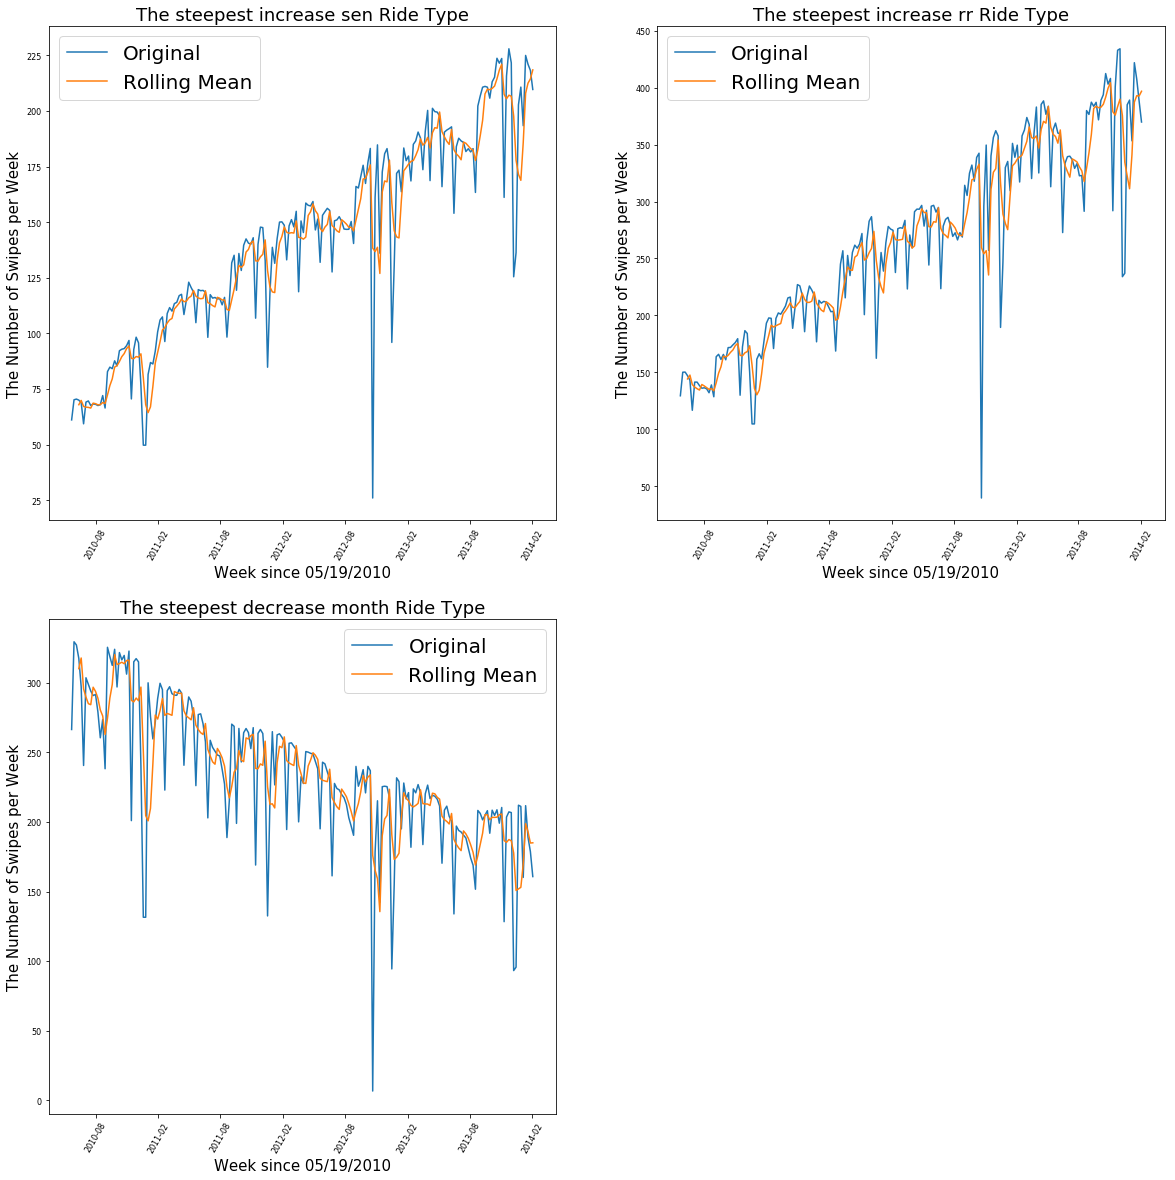

In [26]:
fig = pl.figure(figsize=(20,20))

ax = fig.add_subplot(2,2,1)
#titleName = "The"+ridetype[i]+"Ride Type"
#print(i)
ax.set_title("The steepest increase "+ridetype[16]+" Ride Type",fontsize=18)
pl.xticks(rotation=60, fontsize=8)
pl.yticks(fontsize=8)
pl.xlabel("Week since 05/19/2010",fontsize=15)
pl.ylabel("The Number of Swipes per Week",fontsize=15)
ax.plot(dateRange, mtaRideTypeDf[ridetype[16]], label="Original")
ax.plot(dateRange, mtaRideTypeRollingMean[ridetype[16]], label="Rolling Mean")
pl.legend()

bx = fig.add_subplot(2,2,2)
#titleName = "The"+ridetype[i]+"Ride Type"
#print(i)
bx.set_title("The steepest increase "+ridetype[15]+" Ride Type",fontsize=18)
pl.xticks(rotation=60, fontsize=8)
pl.yticks(fontsize=8)
pl.xlabel("Week since 05/19/2010",fontsize=15)
pl.ylabel("The Number of Swipes per Week",fontsize=15)
bx.plot(dateRange, mtaRideTypeDf[ridetype[15]], label="Original")
bx.plot(dateRange, mtaRideTypeRollingMean[ridetype[15]], label="Rolling Mean")
pl.legend()

bx = fig.add_subplot(2,2,3)
#titleName = "The"+ridetype[i]+"Ride Type"
#print(i)
bx.set_title("The steepest decrease "+ridetype[13]+" Ride Type",fontsize=18)
pl.xticks(rotation=60, fontsize=8)
pl.yticks(fontsize=8)
pl.xlabel("Week since 05/19/2010",fontsize=15)
pl.ylabel("The Number of Swipes per Week",fontsize=15)
bx.plot(dateRange, mtaRideTypeDf[ridetype[13]], label="Original")
bx.plot(dateRange, mtaRideTypeRollingMean[ridetype[13]], label="Rolling Mean")
pl.legend()

## Figure 5

Here is the figure of the Number of Swipes per week in the steepest increase and decrease ride type from 05/19/2010 to 02/8/2014, 194 weeks. From this 3 figures, we can tell that they have trend in it.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [27]:
label = []
tsStations = []
stationid = []
stationsmean = []
stationsstd = []

for i in range(mta.shape[0]):
    tsStation = []
    for j in range(mta.shape[1]):
        if np.isnan(mta[i][j]).sum() == 0:
            label.append(j)
            stationid.append(i)
            tsStation.append(mta[i][j])
            tsStations.append(mta[i][j])
    stationsmean.append(np.mean(tsStation))
    stationsstd.append(np.std(tsStation))
    

label = array(label)
tsStations = array(tsStations)
#stationid = array(stationid)

In [28]:
label.shape

(9174,)

In [29]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21,  0,  1,  2,  3])

In [30]:
tsStations.shape

(9174, 194)

In [31]:
print(len(stationsmean))
print(len(stationsstd))

600
600


you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [32]:
tsmean = np.mean(tsStations,1)
tsstd = np.std(tsStations,1)

In [33]:
normed_time_series_mean = []
normed_time_series_std = []

for i in range(tsStations.shape[0]):
    normed_time_series_mean.append(tsmean[i]/stationsmean[stationid[i]])
    normed_time_series_std.append(tsstd[i]/stationsstd[stationid[i]])

In [34]:
standardizedts = []

for i in range(tsStations.shape[0]):
    standardizedts.append((tsStations[i]-tsmean[i])/tsstd[i])

In [35]:
standardizedts_new = []
label_new = []
normed_time_series_mean_new = []
normed_time_series_std_new = []

for i in range(len(standardizedts)):
    if (~np.isfinite(standardizedts[i])).sum() == 0:
        standardizedts_new.append(standardizedts[i])
        label_new.append(label[i])
        normed_time_series_mean_new.append(normed_time_series_mean[i])
        normed_time_series_std_new.append(normed_time_series_std[i])

standardizedts_new = array(standardizedts_new)
label_new = array(label_new)
normed_time_series_mean_new = array(normed_time_series_mean_new)
normed_time_series_std_new = array(normed_time_series_std_new)

In [36]:
standardizedts_new.shape

(7660, 194)

In [37]:
label_new.shape

(7660,)

Text(0,0.5,'standardized number of rides')

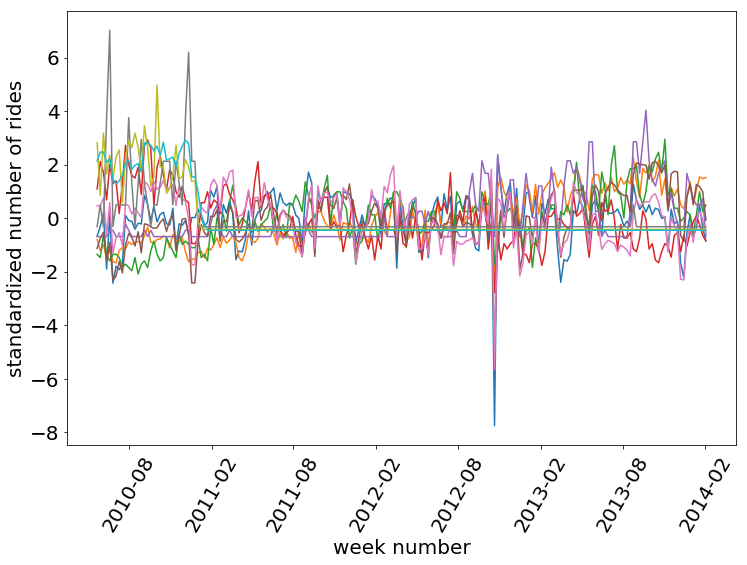

In [38]:
pl.figure(figsize(12,8))
pl.xticks(rotation=60)

for i in range(10):
    pl.plot(dateRange, standardizedts_new[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

## Figure 6

Here is the figure of the first 10 standardized number of rides by station per week from 05/19/2010 to 02/8/2014, 194 weeks. 

In [39]:
allfits = []
for i in range(len(standardizedts_new)):
    smols = sm.OLS(standardizedts_new[i], sm.add_constant(np.array(range(1, 195)))).fit()
    allfits.append(smols)
[a.params[0] for a in allfits[:10]]

[-0.0095141428240503,
 -1.4698038513631968,
 -1.0801459983889143,
 1.078238027640132,
 -1.0339872015345257,
 -0.88039868030637281,
 0.57788406137248371,
 0.75463643817356196,
 1.05547323323655,
 1.1150148854827571]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              normed_time_series_mean_new, normed_time_series_std_new]).T, 
    label_new, test_size=0.33, random_state=42)

In [41]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 4), (2528, 4), (5132,), (2528,))

In [42]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [43]:
clf1 = rfc()
clf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

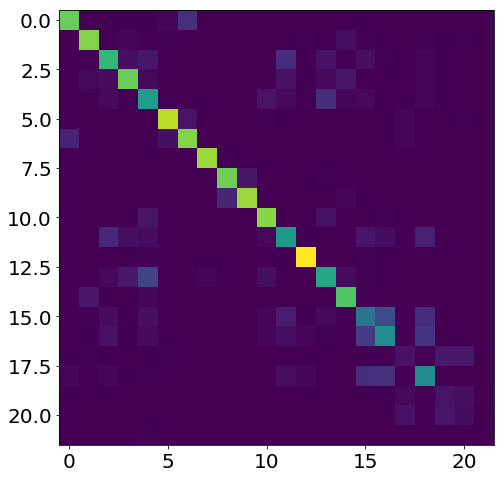

In [44]:
y_pred = clf1.predict(X_test)
imshow(confusion_matrix(y_test, y_pred))

## Figure 7:

Here is the confusion matrix of the classification. The diagonal means the right classification. It do not fit very well after type 15.

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

In [45]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.88      0.84      0.86       135
        14d       0.89      0.90      0.90       133
         1d       0.70      0.66      0.68       148
         2t       0.83      0.78      0.80       147
        30d       0.54      0.66      0.59       124
         7d       0.93      0.92      0.92       144
        ada       0.81      0.85      0.83       142
       afas       0.98      0.99      0.99       126
        exp       0.87      0.92      0.89       125
         ez       0.93      0.87      0.90       143
         ff       0.85      0.88      0.86       137
         mc       0.60      0.58      0.59       138
         mr       0.97      0.99      0.98       149
      month       0.67      0.61      0.64       146
        rfm       0.82      0.90      0.86       119
         rr       0.46      0.41      0.43       138
        sen       0.54      0.51      0.52       142
       spec       0.33      0.24      0.28   

In [46]:
clf1.feature_importances_

array([ 0.20528973,  0.18702006,  0.36809964,  0.23959057])

In [47]:
clf1.feature_importances_.argsort()[-2:][::-1]

array([2, 3])

So the most important features in model1 is normed time series mean and normed time series std.

## Build a model that uses as input features each time stamp (194 features) :


In [48]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(standardizedts_new,label_new, test_size=0.33, random_state=42)

In [49]:
clf2 = rfc()
clf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

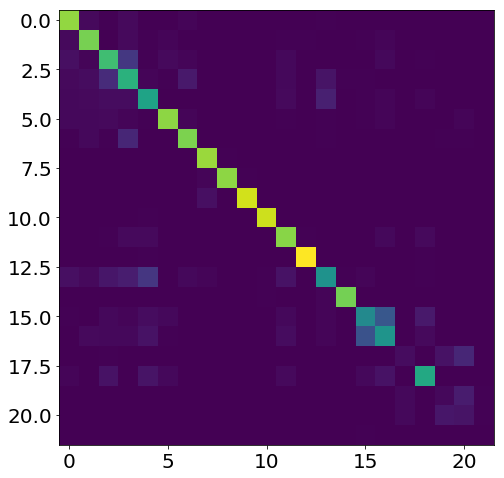

In [50]:
y_pred = clf2.predict(X_test)

imshow(confusion_matrix(y_test, y_pred))

## Figure 8:

Here is the confusion matrix of the classification in 194 features. The diagonal means the right classification. It do not fit very well after type 18.

In [51]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.80      0.91      0.85       135
        14d       0.80      0.88      0.84       133
         1d       0.66      0.69      0.67       148
         2t       0.55      0.64      0.59       147
        30d       0.61      0.69      0.65       124
         7d       0.90      0.85      0.87       144
        ada       0.86      0.83      0.85       142
       afas       0.93      0.99      0.96       126
        exp       0.99      0.98      0.98       125
         ez       0.99      0.96      0.98       143
         ff       0.99      0.99      0.99       137
         mc       0.80      0.88      0.83       138
         mr       0.99      0.99      0.99       149
      month       0.71      0.51      0.60       146
        rfm       0.98      0.97      0.98       119
         rr       0.59      0.50      0.54       138
        sen       0.56      0.54      0.55       142
       spec       0.45      0.17      0.25   

In [52]:
clf2.feature_importances_.argsort()[-2:][::-1]

array([126,  33])

So the most important features in model 2 is 127 week and 34 week.

## Conclusion

From the classification report, clf model 2(the use 194 features one) is better.